In [10]:
# Air Quality Data - Detailed EDA (Updated for Your Data)
# Deep dive into patterns, trends, and relationships

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
%matplotlib inline

pd.set_option('display.max_columns', None)

print("=" * 70)
print("AIR QUALITY DATA - DETAILED ANALYSIS")
print("=" * 70)

AIR QUALITY DATA - DETAILED ANALYSIS


In [11]:
# =============================================================================
# LOAD DATA (Use corrected data if available, otherwise raw)
# =============================================================================

# Try to load corrected data first
processed_dir = Path('../data/processed')
corrected_files = sorted(list(processed_dir.glob('corrected_air_quality_historical*.csv')))

if corrected_files:
    print("\n✓ Using corrected data (AQI values fixed)")
    df = pd.read_csv(corrected_files[-1])
else:
    print("\n⚠️  Using raw data (AQI may need correction)")
    data_dir = Path('../data/raw')
    csv_files = sorted(list(data_dir.glob('air_quality_historical*.csv')))
    
    if not csv_files:
        raise FileNotFoundError("No data found! Run data collection first.")
    
    df = pd.read_csv(csv_files[-1])

df['timestamp'] = pd.to_datetime(df['timestamp'])

print(f"\n✓ Loaded {len(df):,} records")
print(f"  Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"  Cities: {df['city_name'].nunique() if 'city_name' in df.columns else 'Unknown'}")



✓ Using corrected data (AQI values fixed)

✓ Loaded 22,556 records
  Date range: 2025-08-31 18:00:00 to 2025-12-03 16:00:00
  Cities: 10



📅 TEMPORAL PATTERN ANALYSIS
✓ Created temporal features

AQI Statistics:
  Mean: 64.80
  Median: 39.00
  Min: 2.00
  Max: 500.00


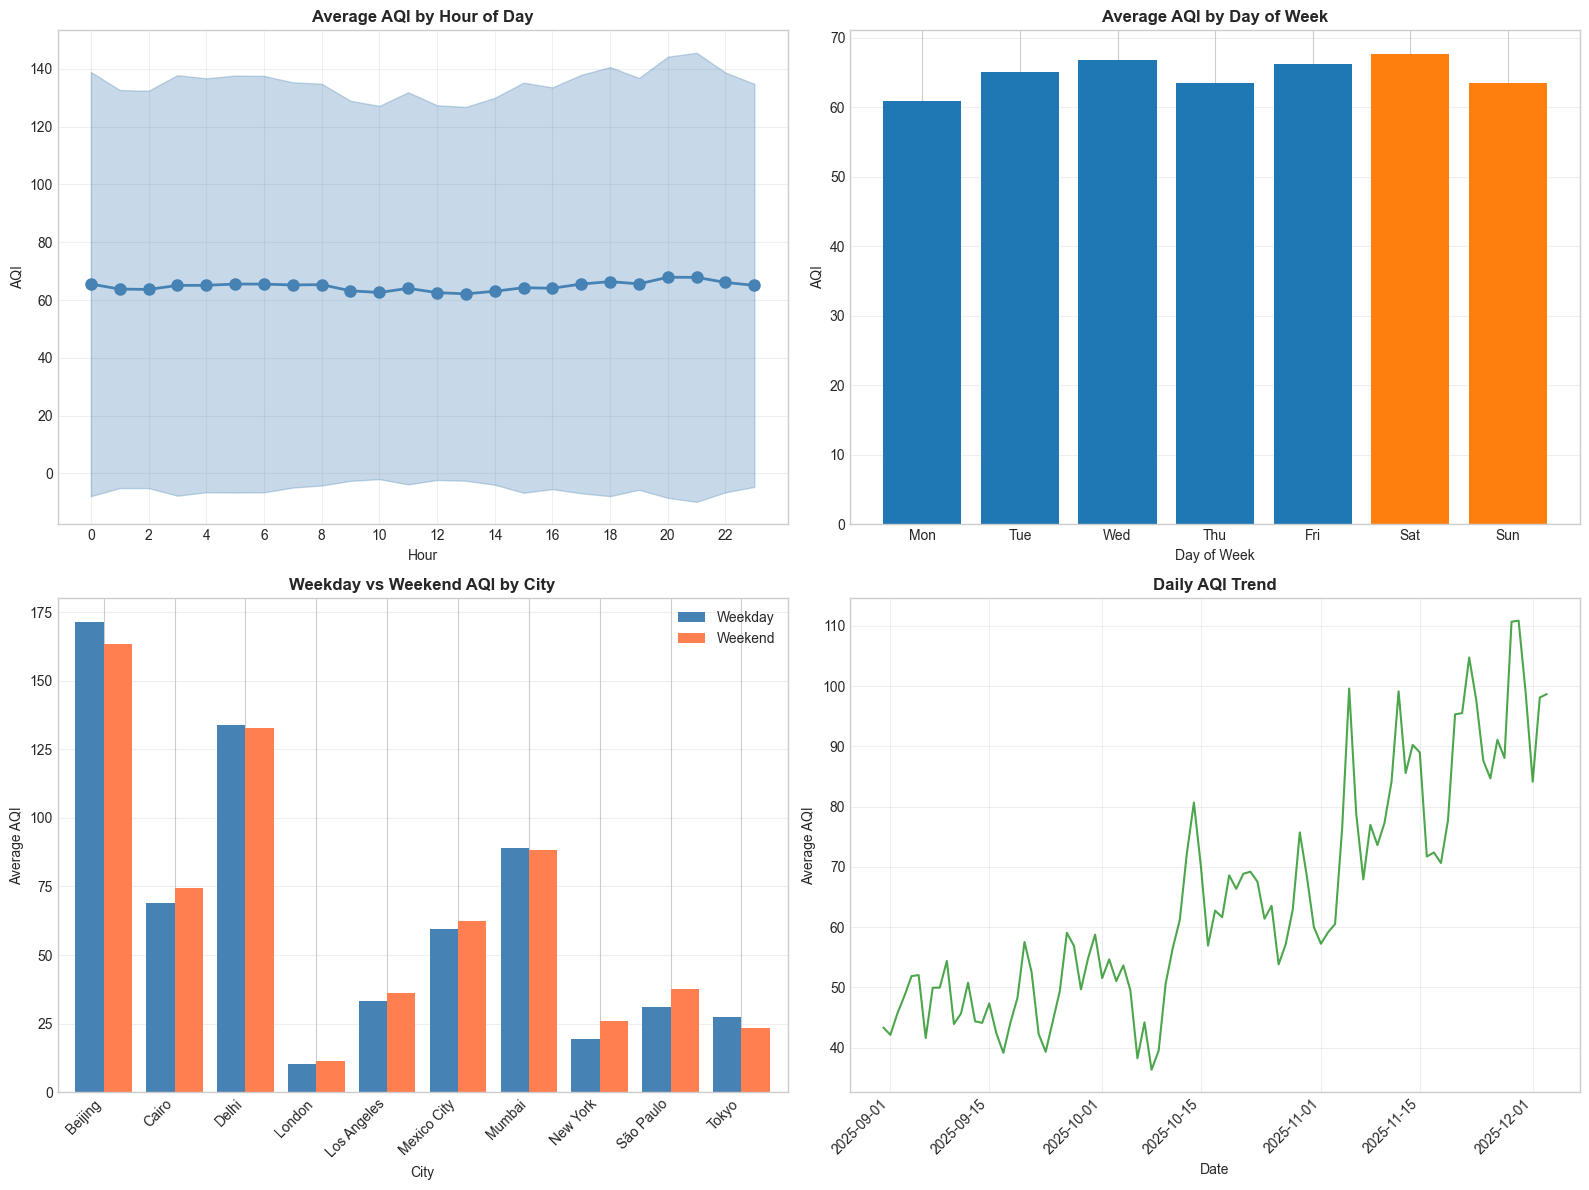

In [12]:
# =============================================================================
# 1. TEMPORAL PATTERNS
# =============================================================================

print("\n" + "=" * 70)
print("📅 TEMPORAL PATTERN ANALYSIS")
print("=" * 70)

# Extract temporal features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['day_name'] = df['timestamp'].dt.day_name()
df['month'] = df['timestamp'].dt.month
df['month_name'] = df['timestamp'].dt.month_name()
df['date'] = df['timestamp'].dt.date
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

print("✓ Created temporal features")

# Check AQI values
print(f"\nAQI Statistics:")
print(f"  Mean: {df['aqi'].mean():.2f}")
print(f"  Median: {df['aqi'].median():.2f}")
print(f"  Min: {df['aqi'].min():.2f}")
print(f"  Max: {df['aqi'].max():.2f}")

if df['aqi'].max() <= 10:
    print("\n⚠️  WARNING: AQI values appear to be on 1-5 scale!")
    print("   Run scripts/fix_aqi_values.py to correct this.")

# Hourly patterns
if 'aqi' in df.columns and df['aqi'].notna().sum() > 100:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # AQI by hour of day
    hourly_aqi = df.groupby('hour')['aqi'].agg(['mean', 'std', 'count']).reset_index()
    hourly_aqi = hourly_aqi[hourly_aqi['count'] > 10]  # Filter hours with enough data
    
    axes[0, 0].plot(hourly_aqi['hour'], hourly_aqi['mean'], 
                    marker='o', linewidth=2, markersize=8, color='steelblue')
    axes[0, 0].fill_between(hourly_aqi['hour'], 
                             hourly_aqi['mean'] - hourly_aqi['std'],
                             hourly_aqi['mean'] + hourly_aqi['std'],
                             alpha=0.3, color='steelblue')
    axes[0, 0].set_title('Average AQI by Hour of Day', fontweight='bold', fontsize=12)
    axes[0, 0].set_xlabel('Hour')
    axes[0, 0].set_ylabel('AQI')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_xticks(range(0, 24, 2))
    
    # AQI by day of week
    dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dow_aqi = df.groupby('day_name')['aqi'].mean().reindex(dow_order)
    colors = ['#1f77b4'] * 5 + ['#ff7f0e'] * 2  # Different colors for weekends
    axes[0, 1].bar(range(7), dow_aqi.values, color=colors)
    axes[0, 1].set_title('Average AQI by Day of Week', fontweight='bold', fontsize=12)
    axes[0, 1].set_xlabel('Day of Week')
    axes[0, 1].set_ylabel('AQI')
    axes[0, 1].set_xticks(range(7))
    axes[0, 1].set_xticklabels([d[:3] for d in dow_order], rotation=0)
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Weekend vs Weekday
    weekend_comp = df.groupby(['is_weekend', 'city_name'])['aqi'].mean().reset_index()
    weekend_pivot = weekend_comp.pivot(index='city_name', columns='is_weekend', values='aqi')
    
    if not weekend_pivot.empty:
        weekend_pivot.plot(kind='bar', ax=axes[1, 0], 
                          color=['steelblue', 'coral'],
                          width=0.8)
        axes[1, 0].set_title('Weekday vs Weekend AQI by City', fontweight='bold', fontsize=12)
        axes[1, 0].set_xlabel('City')
        axes[1, 0].set_ylabel('Average AQI')
        axes[1, 0].legend(['Weekday', 'Weekend'])
        axes[1, 0].grid(True, alpha=0.3, axis='y')
        plt.setp(axes[1, 0].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Daily trends over time
    daily_aqi = df.groupby('date')['aqi'].mean()
    axes[1, 1].plot(daily_aqi.index, daily_aqi.values, 
                    linewidth=1.5, color='green', alpha=0.7)
    axes[1, 1].set_title('Daily AQI Trend', fontweight='bold', fontsize=12)
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].set_ylabel('Average AQI')
    axes[1, 1].grid(True, alpha=0.3)
    plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()


🌍 GEOGRAPHIC PATTERN ANALYSIS

📊 AQI Statistics by City:
----------------------------------------------------------------------


,Mean_AQI,Median_AQI,Std_Dev,Min_AQI,Max_AQI,Records
city_name,,,,,,
Beijing,169.20,169.0,79.30,15,500,2258
Delhi,133.55,147.0,61.79,19,500,2258
Mumbai,88.93,47.0,82.38,4,500,2258
Cairo,70.41,63.0,44.11,13,500,2258
Mexico City,60.38,56.0,50.39,7,500,2258
Los Angeles,34.00,25.0,33.64,2,500,2234
São Paulo,33.02,22.0,35.96,3,500,2258
Tokyo,26.26,19.0,26.50,2,500,2258
New York,21.37,15.0,20.07,2,500,2258


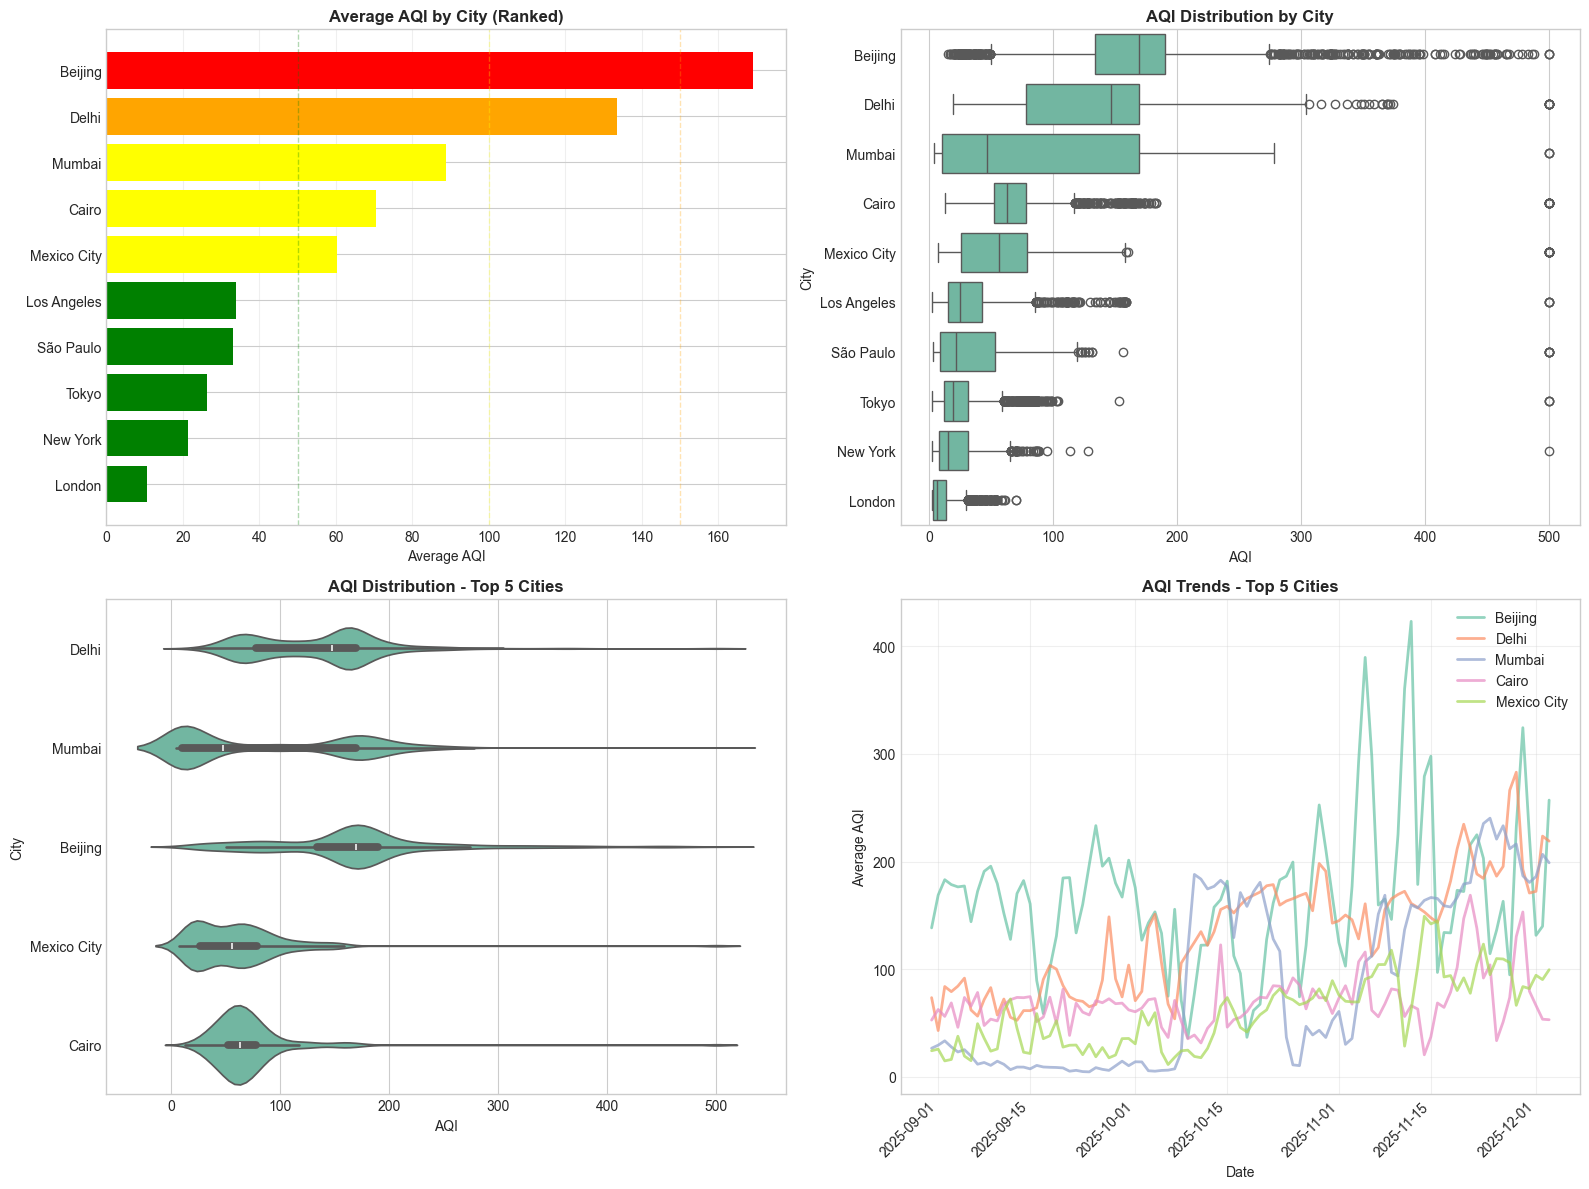

In [13]:
# =============================================================================
# 2. GEOGRAPHIC PATTERNS
# =============================================================================

print("\n" + "=" * 70)
print("🌍 GEOGRAPHIC PATTERN ANALYSIS")
print("=" * 70)

if 'city_name' in df.columns and 'aqi' in df.columns:
    # City statistics
    city_stats = df.groupby('city_name')['aqi'].agg([
        ('Mean_AQI', 'mean'),
        ('Median_AQI', 'median'),
        ('Std_Dev', 'std'),
        ('Min_AQI', 'min'),
        ('Max_AQI', 'max'),
        ('Records', 'count')
    ]).round(2).sort_values('Mean_AQI', ascending=False)
    
    print("\n📊 AQI Statistics by City:")
    print("-" * 70)
    display(city_stats)
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Ranked bar chart with AQI color coding
    city_means = city_stats['Mean_AQI'].sort_values(ascending=True)
    
    def get_aqi_color(aqi):
        if aqi <= 50:
            return 'green'
        elif aqi <= 100:
            return 'yellow'
        elif aqi <= 150:
            return 'orange'
        elif aqi <= 200:
            return 'red'
        elif aqi <= 300:
            return 'purple'
        else:
            return 'maroon'
    
    colors = [get_aqi_color(x) for x in city_means.values]
    
    axes[0, 0].barh(range(len(city_means)), city_means.values, color=colors)
    axes[0, 0].set_yticks(range(len(city_means)))
    axes[0, 0].set_yticklabels(city_means.index)
    axes[0, 0].set_title('Average AQI by City (Ranked)', fontweight='bold', fontsize=12)
    axes[0, 0].set_xlabel('Average AQI')
    axes[0, 0].axvline(50, color='green', linestyle='--', alpha=0.3, linewidth=1)
    axes[0, 0].axvline(100, color='yellow', linestyle='--', alpha=0.3, linewidth=1)
    axes[0, 0].axvline(150, color='orange', linestyle='--', alpha=0.3, linewidth=1)
    axes[0, 0].grid(True, alpha=0.3, axis='x')
    
    # Box plot by city
    cities_with_data = city_stats[city_stats['Records'] >= 100].index[:10]
    df_plot = df[df['city_name'].isin(cities_with_data)]
    
    if not df_plot.empty:
        sns.boxplot(data=df_plot, y='city_name', x='aqi', ax=axes[0, 1],
                   order=city_stats.loc[cities_with_data, 'Mean_AQI'].sort_values(ascending=False).index)
        axes[0, 1].set_title('AQI Distribution by City', fontweight='bold', fontsize=12)
        axes[0, 1].set_xlabel('AQI')
        axes[0, 1].set_ylabel('City')
    
    # Violin plot (top 5 cities)
    top5_cities = city_stats.nlargest(5, 'Records').index
    df_top5 = df[df['city_name'].isin(top5_cities)]
    
    if not df_top5.empty:
        sns.violinplot(data=df_top5, y='city_name', x='aqi', ax=axes[1, 0])
        axes[1, 0].set_title('AQI Distribution - Top 5 Cities', fontweight='bold', fontsize=12)
        axes[1, 0].set_xlabel('AQI')
        axes[1, 0].set_ylabel('City')
    
    # Time series comparison
    for city in top5_cities:
        city_daily = df[df['city_name'] == city].groupby('date')['aqi'].mean()
        axes[1, 1].plot(city_daily.index, city_daily.values, 
                       label=city, linewidth=2, alpha=0.7)
    
    axes[1, 1].set_title('AQI Trends - Top 5 Cities', fontweight='bold', fontsize=12)
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].set_ylabel('Average AQI')
    axes[1, 1].legend(loc='best')
    axes[1, 1].grid(True, alpha=0.3)
    plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()


🏭 POLLUTANT ANALYSIS

Analyzing pollutants: pm25, pm10, no2, so2, o3, co

📊 Pollutant Statistics:
----------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
pm25,22556.0,29.050012,48.424650,0.50,3.290,9.330,28.2400,482.43
pm10,22556.0,43.207258,63.023883,0.50,6.610,16.815,52.1025,853.99
no2,22556.0,9.137178,16.026452,0.03,1.030,3.650,9.0100,145.79
so2,22556.0,5.630073,10.211156,0.05,0.710,2.110,6.3800,205.53
o3,22556.0,70.889013,36.060790,0.00,46.240,71.545,90.0200,254.95
co,22556.0,254.037717,308.969326,2.00,105.805,138.280,285.8525,3647.48


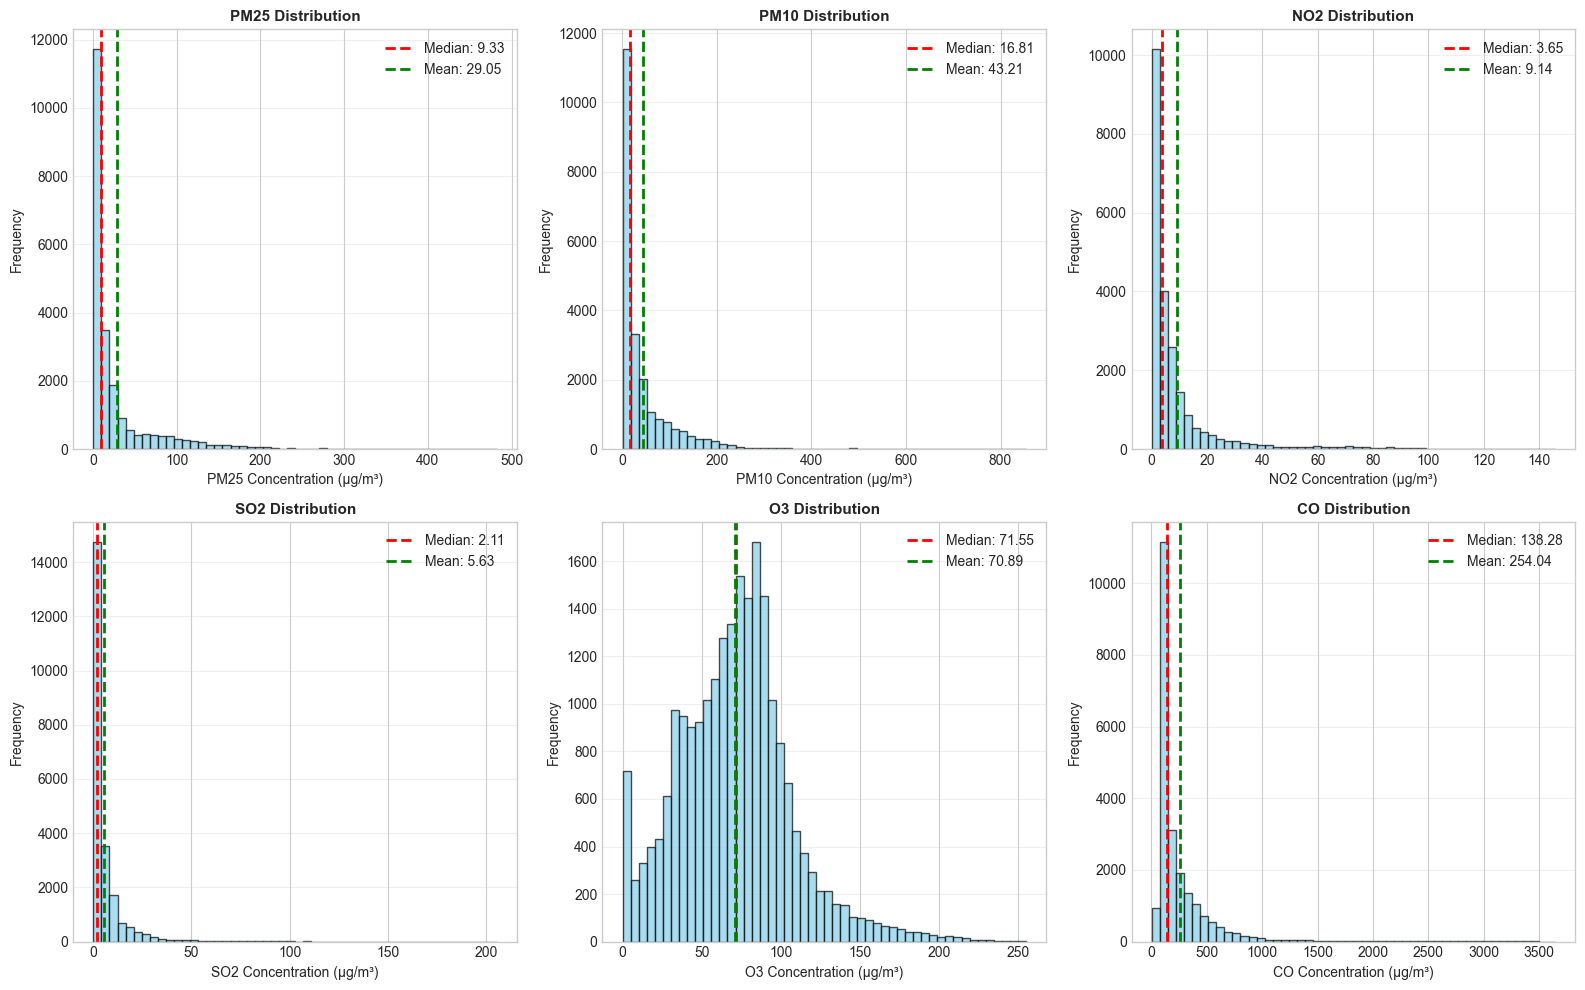

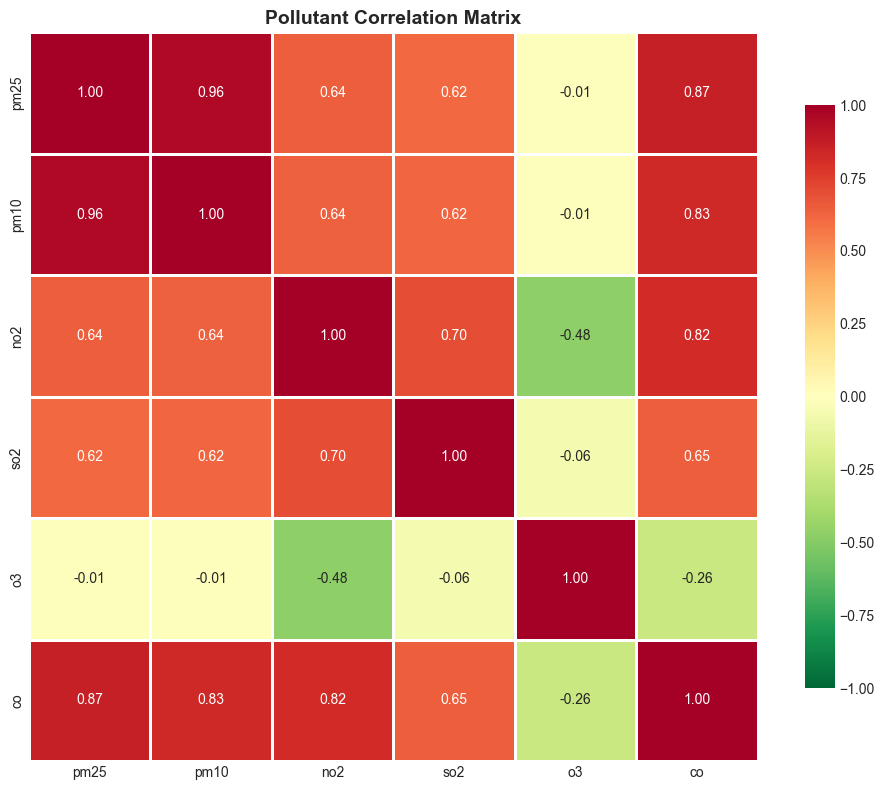

In [14]:
# =============================================================================
# 3. POLLUTANT ANALYSIS
# =============================================================================

print("\n" + "=" * 70)
print("🏭 POLLUTANT ANALYSIS")
print("=" * 70)

pollutants = ['pm25', 'pm10', 'no2', 'so2', 'o3', 'co']
available_pollutants = [p for p in pollutants if p in df.columns and df[p].notna().sum() > 100]

if available_pollutants:
    print(f"\nAnalyzing pollutants: {', '.join(available_pollutants)}")
    
    # Statistics
    pollutant_stats = df[available_pollutants].describe().T
    print("\n📊 Pollutant Statistics:")
    print("-" * 70)
    display(pollutant_stats)
    
    # Distribution plots
    n_pollutants = len(available_pollutants)
    n_cols = 3
    n_rows = (n_pollutants + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
    if n_rows == 1:
        axes = [axes]
    axes = [ax for row in axes for ax in (row if hasattr(row, '__iter__') else [row])]
    
    for idx, pollutant in enumerate(available_pollutants):
        data = df[pollutant].dropna()
        
        if len(data) > 0:
            axes[idx].hist(data, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
            axes[idx].axvline(data.median(), color='red', linestyle='--', 
                             linewidth=2, label=f'Median: {data.median():.2f}')
            axes[idx].axvline(data.mean(), color='green', linestyle='--',
                             linewidth=2, label=f'Mean: {data.mean():.2f}')
            axes[idx].set_title(f'{pollutant.upper()} Distribution', 
                               fontweight='bold', fontsize=11)
            axes[idx].set_xlabel(f'{pollutant.upper()} Concentration (µg/m³)')
            axes[idx].set_ylabel('Frequency')
            axes[idx].legend()
            axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Hide unused subplots
    for idx in range(len(available_pollutants), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Pollutant correlations
    if len(available_pollutants) > 1:
        fig, ax = plt.subplots(figsize=(10, 8))
        pollutant_corr = df[available_pollutants].corr()
        sns.heatmap(pollutant_corr, annot=True, fmt='.2f', 
                   cmap='RdYlGn_r', center=0, square=True,
                   linewidths=2, ax=ax, cbar_kws={"shrink": 0.8},
                   vmin=-1, vmax=1)
        ax.set_title('Pollutant Correlation Matrix', fontweight='bold', fontsize=14)
        plt.tight_layout()
        plt.show()



🌤️ WEATHER IMPACT ON AIR QUALITY

Analyzing: temperature, humidity, pressure, wind_speed


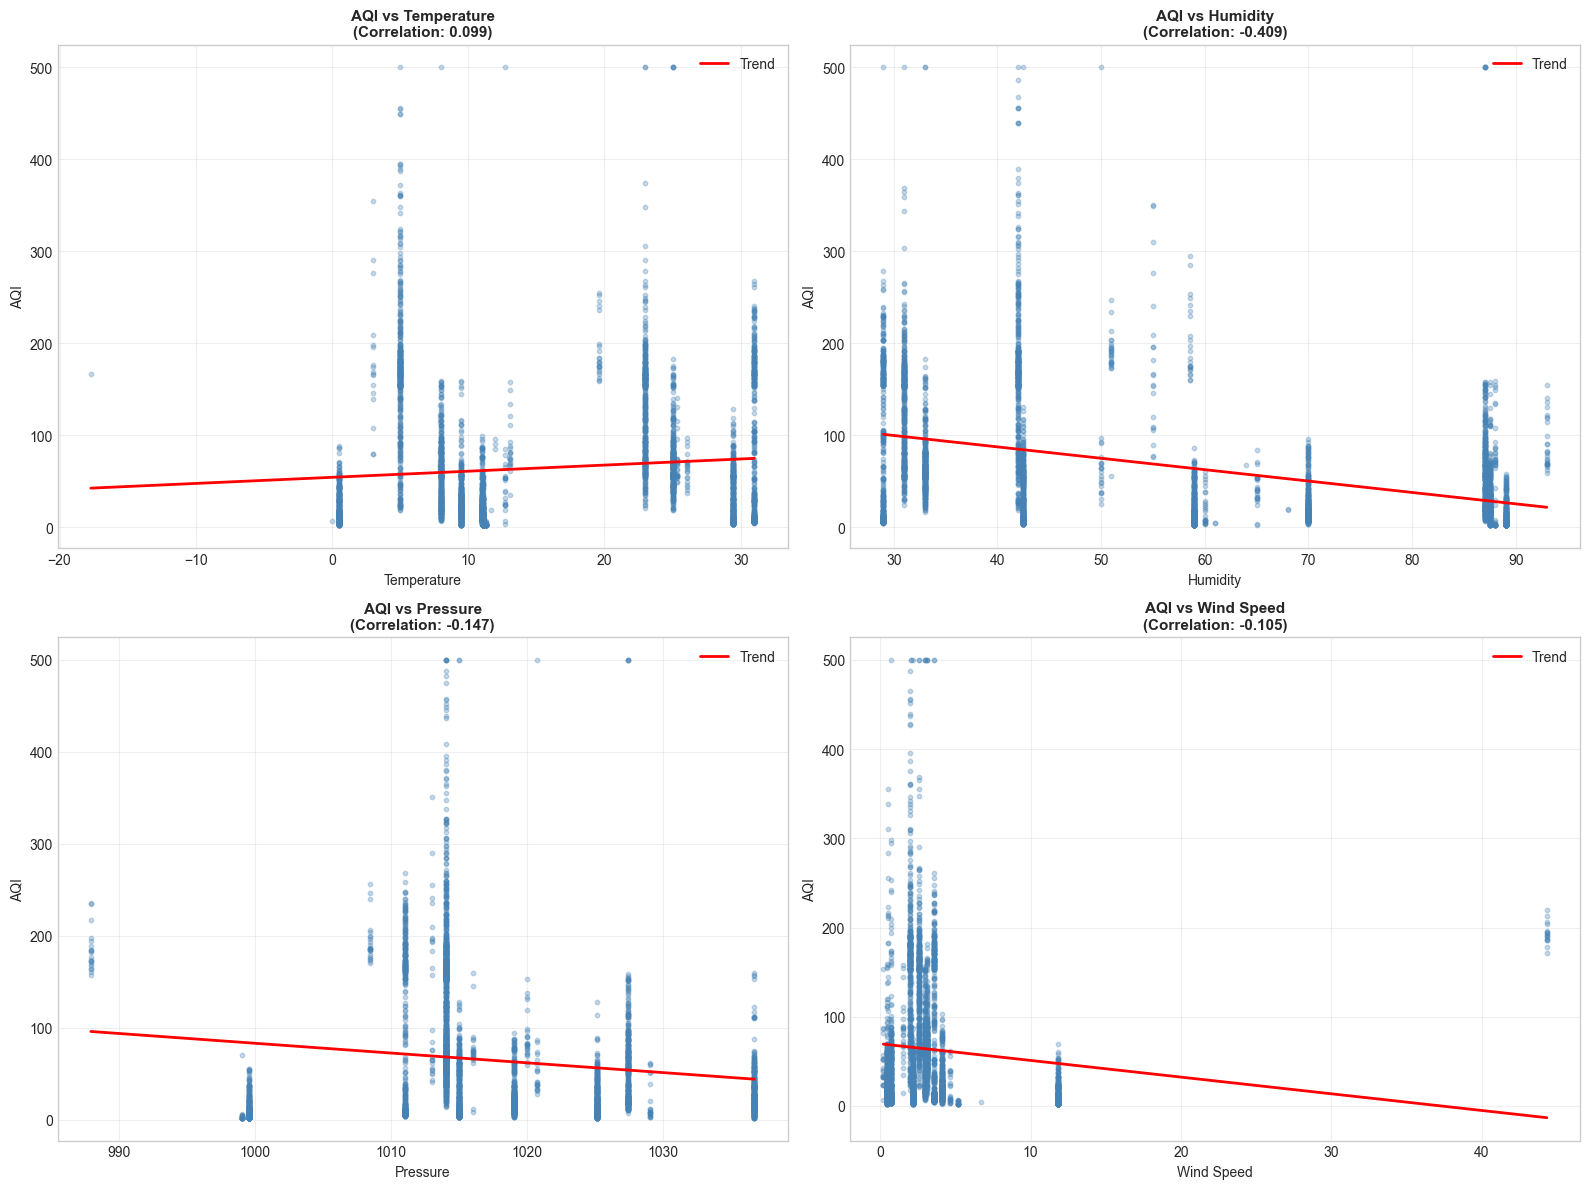


📊 Weather-AQI Correlations:
----------------------------------------------------------------------


,Correlation
temperature,0.089919
wind_speed,-0.083476
pressure,-0.136342
humidity,-0.411878


In [15]:
# =============================================================================
# 4. WEATHER IMPACT ANALYSIS
# =============================================================================

print("\n" + "=" * 70)
print("🌤️ WEATHER IMPACT ON AIR QUALITY")
print("=" * 70)

weather_vars = ['temperature', 'humidity', 'pressure', 'wind_speed']
available_weather = [w for w in weather_vars if w in df.columns and df[w].notna().sum() > 100]

if available_weather and 'aqi' in df.columns:
    print(f"\nAnalyzing: {', '.join(available_weather)}")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, weather_var in enumerate(available_weather[:4]):
        valid_data = df[[weather_var, 'aqi']].dropna()
        
        if len(valid_data) > 10:
            # Sample if too many points
            if len(valid_data) > 5000:
                valid_data = valid_data.sample(5000)
            
            axes[idx].scatter(valid_data[weather_var], valid_data['aqi'], 
                            alpha=0.3, s=10, color='steelblue')
            
            # Trend line
            z = np.polyfit(valid_data[weather_var], valid_data['aqi'], 1)
            p = np.poly1d(z)
            x_line = np.linspace(valid_data[weather_var].min(), 
                               valid_data[weather_var].max(), 100)
            axes[idx].plot(x_line, p(x_line), 'r-', linewidth=2, label='Trend')
            
            # Correlation
            corr = valid_data[weather_var].corr(valid_data['aqi'])
            axes[idx].set_title(f'AQI vs {weather_var.replace("_", " ").title()}\n(Correlation: {corr:.3f})', 
                              fontweight='bold', fontsize=11)
            axes[idx].set_xlabel(weather_var.replace('_', ' ').title())
            axes[idx].set_ylabel('AQI')
            axes[idx].legend()
            axes[idx].grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(available_weather), 4):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Correlation summary
    weather_aqi_corr = df[available_weather + ['aqi']].corr()['aqi'].drop('aqi').sort_values(ascending=False)
    print("\n📊 Weather-AQI Correlations:")
    print("-" * 70)
    display(pd.DataFrame({'Correlation': weather_aqi_corr}))


🔬 PM2.5 vs AQI RELATIONSHIP


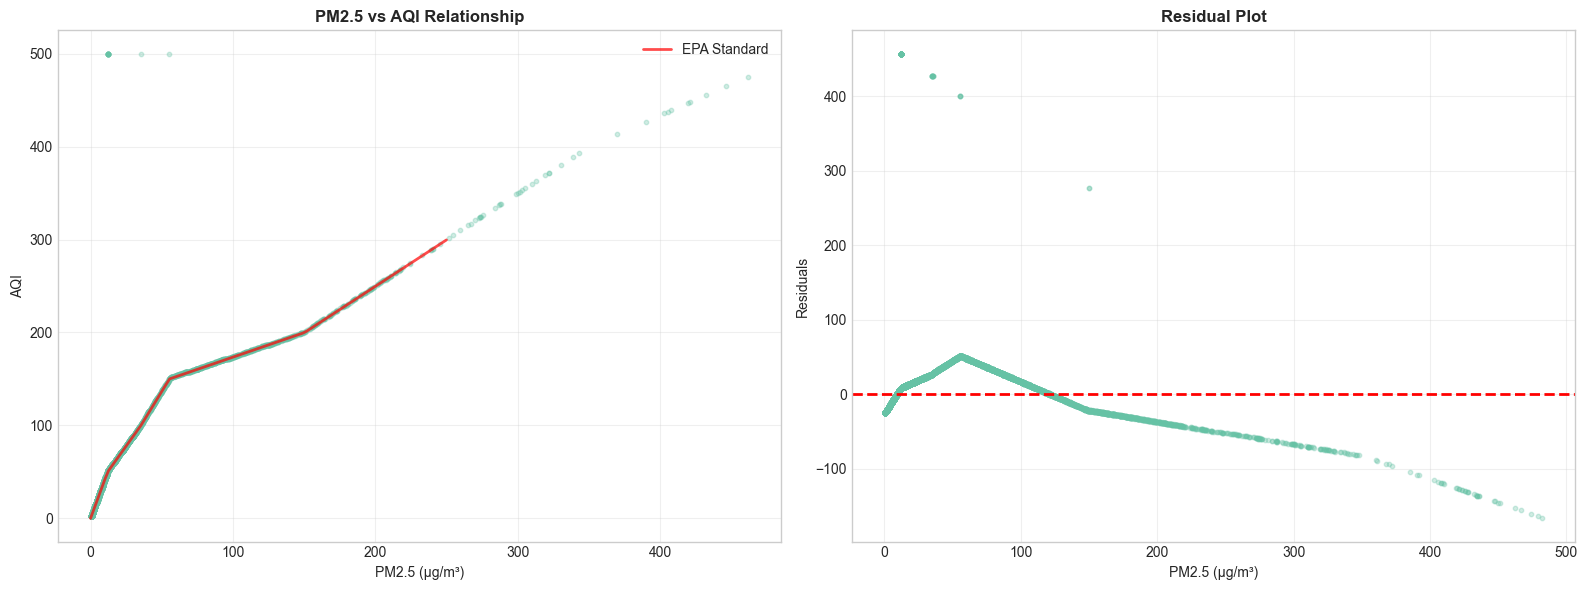


PM2.5 vs AQI correlation: 0.895


In [16]:
# =============================================================================
# 5. PM2.5 vs AQI RELATIONSHIP (Important!)
# =============================================================================

print("\n" + "=" * 70)
print("🔬 PM2.5 vs AQI RELATIONSHIP")
print("=" * 70)

if 'pm25' in df.columns and 'aqi' in df.columns:
    valid_data = df[['pm25', 'aqi']].dropna()
    
    if len(valid_data) > 10:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Scatter plot
        sample_data = valid_data.sample(min(5000, len(valid_data)))
        axes[0].scatter(sample_data['pm25'], sample_data['aqi'], 
                       alpha=0.3, s=10)
        
        # Add EPA standard line (theoretical relationship)
        pm25_range = np.linspace(0, 250, 100)
        
        # This is a simplified EPA calculation
        def pm25_to_aqi_approx(pm25):
            if pm25 <= 12.0:
                return 50 * pm25 / 12.0
            elif pm25 <= 35.4:
                return 50 + 50 * (pm25 - 12.0) / (35.4 - 12.0)
            elif pm25 <= 55.4:
                return 100 + 50 * (pm25 - 35.4) / (55.4 - 35.4)
            elif pm25 <= 150.4:
                return 150 + 50 * (pm25 - 55.4) / (150.4 - 55.4)
            else:
                return 200 + 100 * (pm25 - 150.4) / (250.4 - 150.4)
        
        aqi_theoretical = [pm25_to_aqi_approx(pm) for pm in pm25_range]
        axes[0].plot(pm25_range, aqi_theoretical, 'r-', linewidth=2, 
                    label='EPA Standard', alpha=0.7)
        
        axes[0].set_title('PM2.5 vs AQI Relationship', fontweight='bold', fontsize=12)
        axes[0].set_xlabel('PM2.5 (µg/m³)')
        axes[0].set_ylabel('AQI')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Residual plot
        actual_trend = np.polyfit(valid_data['pm25'], valid_data['aqi'], 1)
        actual_fit = np.poly1d(actual_trend)
        residuals = valid_data['aqi'] - actual_fit(valid_data['pm25'])
        
        axes[1].scatter(valid_data['pm25'], residuals, alpha=0.3, s=10)
        axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
        axes[1].set_title('Residual Plot', fontweight='bold', fontsize=12)
        axes[1].set_xlabel('PM2.5 (µg/m³)')
        axes[1].set_ylabel('Residuals')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Calculate correlation
        corr = valid_data['pm25'].corr(valid_data['aqi'])
        print(f"\nPM2.5 vs AQI correlation: {corr:.3f}")
        
        if corr < 0.5:
            print("⚠️  Warning: Low correlation suggests AQI might not be properly calculated!")
            print("   Consider running scripts/fix_aqi_values.py")

In [17]:
# =============================================================================
# 6. KEY FINDINGS
# =============================================================================

print("\n" + "=" * 70)
print("💡 KEY FINDINGS SUMMARY")
print("=" * 70)

findings = []

# AQI statistics
if 'aqi' in df.columns:
    mean_aqi = df['aqi'].mean()
    median_aqi = df['aqi'].median()
    findings.append(f"📊 Overall AQI: Mean = {mean_aqi:.1f}, Median = {median_aqi:.1f}")
    
    if mean_aqi > 150:
        findings.append("⚠️  Average AQI indicates unhealthy air quality!")
    elif mean_aqi > 100:
        findings.append("⚠️  Average AQI is unhealthy for sensitive groups")
    else:
        findings.append("✓ Average AQI indicates acceptable air quality")

# Peak pollution
if 'hour' in df.columns and 'aqi' in df.columns:
    hourly_avg = df.groupby('hour')['aqi'].mean()
    peak_hour = hourly_avg.idxmax()
    findings.append(f"🕐 Peak pollution typically at {int(peak_hour)}:00 hours")

# Most polluted city
if 'city_name' in df.columns and 'aqi' in df.columns:
    city_avg = df.groupby('city_name')['aqi'].mean()
    most_polluted = city_avg.idxmax()
    most_aqi = city_avg.max()
    least_polluted = city_avg.idxmin()
    least_aqi = city_avg.min()
    findings.append(f"🏙️  Most polluted: {most_polluted} (AQI: {most_aqi:.1f})")
    findings.append(f"🌳 Least polluted: {least_polluted} (AQI: {least_aqi:.1f})")

# Weather correlation
if available_weather and 'aqi' in df.columns:
    weather_corr = df[available_weather + ['aqi']].corr()['aqi'].drop('aqi')
    strongest = weather_corr.abs().idxmax()
    corr_val = weather_corr[strongest]
    findings.append(f"🌤️  {strongest.title()} shows strongest correlation with AQI: {corr_val:.3f}")

# Weekend effect
if 'is_weekend' in df.columns and 'aqi' in df.columns:
    weekday_aqi = df[df['is_weekend'] == 0]['aqi'].mean()
    weekend_aqi = df[df['is_weekend'] == 1]['aqi'].mean()
    diff_pct = ((weekend_aqi - weekday_aqi) / weekday_aqi) * 100
    findings.append(f"📅 Weekend AQI is {diff_pct:+.1f}% vs weekdays")

print("\n")
for i, finding in enumerate(findings, 1):
    print(f"{i}. {finding}")


💡 KEY FINDINGS SUMMARY


1. 📊 Overall AQI: Mean = 64.8, Median = 39.0
2. ✓ Average AQI indicates acceptable air quality
3. 🕐 Peak pollution typically at 20:00 hours
4. 🏙️  Most polluted: Beijing (AQI: 169.2)
5. 🌳 Least polluted: London (AQI: 10.5)
6. 🌤️  Humidity shows strongest correlation with AQI: -0.412
7. 📅 Weekend AQI is +1.7% vs weekdays


In [18]:
# =============================================================================
# SAVE PROCESSED DATA
# =============================================================================

print("\n" + "=" * 70)
print("💾 SAVING ANALYSIS OUTPUTS")
print("=" * 70)

# Save enhanced dataset
output_dir = Path('../data/processed')
output_dir.mkdir(exist_ok=True)

output_path = output_dir / 'air_quality_with_features.csv'
df.to_csv(output_path, index=False)
print(f"✓ Saved: {output_path}")

# Save city statistics
if 'city_name' in df.columns:
    city_stats.to_csv(output_dir / 'city_statistics.csv')
    print("✓ Saved: city_statistics.csv")

# Save findings
findings_df = pd.DataFrame({'Finding': findings})
findings_df.to_csv(output_dir / 'eda_findings.csv', index=False)
print("✓ Saved: eda_findings.csv")

print("\n" + "=" * 70)
print("✅ DETAILED EDA COMPLETE!")
print("=" * 70)
print("\nNext steps:")
print("1. Review all findings and visualizations")
print("2. If AQI values seem wrong, run: python scripts/fix_aqi_values.py")
print("3. Proceed to Phase 4: Feature Engineering")


💾 SAVING ANALYSIS OUTPUTS
✓ Saved: ..\data\processed\air_quality_with_features.csv
✓ Saved: city_statistics.csv
✓ Saved: eda_findings.csv

✅ DETAILED EDA COMPLETE!

Next steps:
1. Review all findings and visualizations
2. If AQI values seem wrong, run: python scripts/fix_aqi_values.py
3. Proceed to Phase 4: Feature Engineering
